In [1]:
import sys, os, time
import torch
sys.path.append("../src/")
from run_pdebench_finetuning import get_args, get_model, build_pdebench_dataset
from engine_for_pdebench_finetuning import get_targets, unnorm_batch
import utils
from einops import rearrange
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model_dir = 'pdebench_finetuning/k400_s/k400_s_turb_512_sweeps/avw0r5gd/k400_s_turb_512_sweeps_lr_0.006360'

args_json = os.path.join(utils.get_ceph_dir(), model_dir, "args.json")
args = utils.load_args(args_json)

args.num_workers = 1
args.device = 'cuda:0'
args.checkpoint = os.path.join(model_dir, 'checkpoint-49')

In [3]:
print("Dataset:\t\t", args.data_set)
print("Fields:\t\t\t", args.fields)
print("Model:\t\t\t", args.model)
print("Checkpoint:\t\t", args.checkpoint)
print("Batch size:\t\t", args.batch_size)
print("Number of workers:\t", args.num_workers)
print("Mask type:\t\t", args.mask_type)
print("Mask ratio:\t\t", args.mask_ratio)
print("Norm target mode:\t", args.norm_target_mode)
print("Num frames:\t\t", args.num_frames)
print("Device:\t\t\t", args.device)

Dataset:		 compNS_turb
Fields:			 ['Vx', 'Vy', 'density']
Model:			 pretrain_videomae_small_patch16_512
Checkpoint:		 pdebench_finetuning/k400_s/k400_s_turb_512_sweeps/avw0r5gd/k400_s_turb_512_sweeps_lr_0.006360/checkpoint-49
Batch size:		 1
Number of workers:	 1
Mask type:		 last_frame
Mask ratio:		 0.9
Norm target mode:	 last_frame
Num frames:		 16
Device:			 cuda:0


In [4]:
device = torch.device(args.device)

# Load model
model = get_model(args)
model.to(device)
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Model loaded")
print('number of params: {} M'.format(n_parameters / 1e6))

# Load dataset
dataset = build_pdebench_dataset(args, set_type='test')
dataset.timesteps = 21
dataset.random_start = False

# Data loader
# sampler = torch.utils.data.RandomSampler(dataset)
sampler = torch.utils.data.SequentialSampler(dataset)
data_loader = torch.utils.data.DataLoader(
        dataset, sampler=sampler,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        pin_memory=args.pin_mem,
        drop_last=True,
        worker_init_fn=utils.seed_worker)

Creating model: pretrain_videomae_small_patch16_512
Position interpolate from 14x14 to 32x32
Position interpolate from 14x14 to 32x32
Model loaded
number of params: 24.029376 M
Raw dataset compNS_turb has 1000 samples of shape (512, 512) and 21 timesteps.


In [5]:
def plot_reconstruction(truth, recon):
    truth = truth[0].cpu().numpy()
    recon = recon[0].cpu().numpy()

    nframes = truth.shape[1]
    
    vmin = np.min(truth, axis=(-1, -2, -3))
    vmax = np.max(truth, axis=(-1, -2, -3))

    fig, axs = plt.subplots(nframes, 2*len(args.fields), figsize=(6*len(args.fields), 3*nframes), sharex=True, sharey=True)
    for i in range(nframes):
        for j in range(len(args.fields)):
            axs[i, 2*j].imshow(truth[j, i, :, :], vmin=vmin[j], vmax=vmax[j])
            axs[i, 2*j+1].imshow(recon[j, i, :, :], vmin=vmin[j], vmax=vmax[j])
        axs[i, 0].set_ylabel('Frame {}'.format(i))
    for j in range(len(args.fields)):
        axs[0, 2*j].set_title(args.fields[j] + ' (truth)')
        axs[0, 2*j+1].set_title(args.fields[j] + ' (recon)')
    fig.tight_layout()
    plt.show()


torch.Size([1, 3, 16, 512, 512]) torch.Size([1, 1024, 1536])
MSE Loss for frame 16: 0.2562487721443176
torch.Size([1, 3, 16, 512, 512]) torch.Size([1, 1024, 1536])
MSE Loss for frame 17: 0.465036004781723
torch.Size([1, 3, 16, 512, 512]) torch.Size([1, 1024, 1536])
MSE Loss for frame 18: 0.31105276942253113
torch.Size([1, 3, 16, 512, 512]) torch.Size([1, 1024, 1536])
MSE Loss for frame 19: 0.22293496131896973
torch.Size([1, 3, 16, 512, 512]) torch.Size([1, 1024, 1536])
MSE Loss for frame 20: 0.4640660285949707
torch.Size([1, 3, 16, 512, 512]) torch.Size([1, 1024, 1536])
MSE Loss for frame 21: 0.4656083583831787
torch.Size([1, 3, 16, 512, 512])
torch.Size([1, 3, 15, 512, 512])
torch.Size([1, 3, 16, 512, 512]) torch.Size([1, 1024, 1536])
MSE Loss for frame 22: 0.3915114402770996


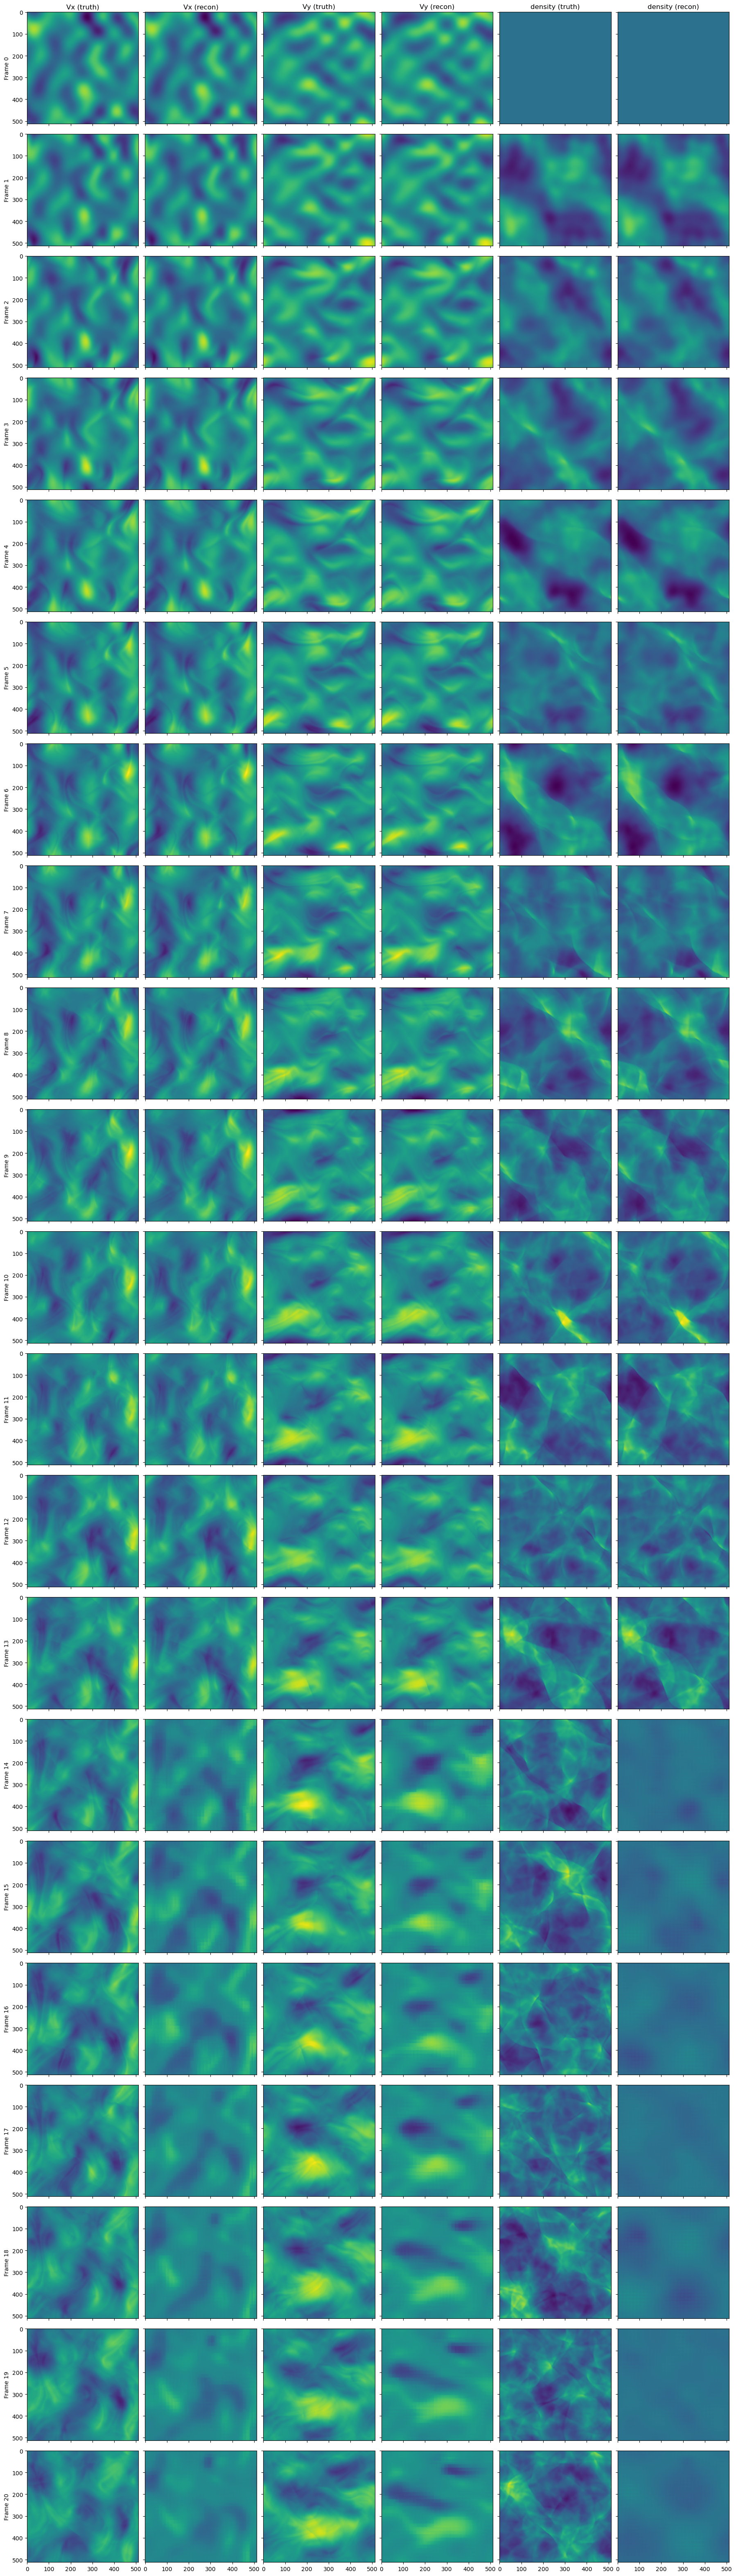

torch.Size([1, 3, 16, 512, 512]) torch.Size([1, 1024, 1536])
MSE Loss for frame 16: 0.2464064061641693
torch.Size([1, 3, 16, 512, 512]) torch.Size([1, 1024, 1536])
MSE Loss for frame 17: 0.10625328123569489
torch.Size([1, 3, 16, 512, 512]) torch.Size([1, 1024, 1536])
MSE Loss for frame 18: 0.048652440309524536
torch.Size([1, 3, 16, 512, 512]) torch.Size([1, 1024, 1536])
MSE Loss for frame 19: 0.13250309228897095
torch.Size([1, 3, 16, 512, 512]) torch.Size([1, 1024, 1536])
MSE Loss for frame 20: 0.3008299469947815
torch.Size([1, 3, 16, 512, 512]) torch.Size([1, 1024, 1536])
MSE Loss for frame 21: 0.4424874484539032
torch.Size([1, 3, 16, 512, 512])
torch.Size([1, 3, 15, 512, 512])
torch.Size([1, 3, 16, 512, 512]) torch.Size([1, 1024, 1536])
MSE Loss for frame 22: 0.5810952186584473


KeyboardInterrupt: 

In [17]:
loss_func = nn.MSELoss()

max_examples = 5
model.eval()
for samples_base, masks in data_loader:
    samples_base = samples_base.to(device, non_blocking=True)
    samples_truth = samples_base.clone()
    bool_masked_pos = masks.to(device, non_blocking=True).flatten(1).to(torch.bool)

    p0, p1, p2 = 2, args.patch_size[0], args.patch_size[1]
    h, w = args.input_size // p1, args.input_size // p2
    nchan = samples_base.shape[1]

    for i in range(args.num_frames, 23):
        samples = samples_base[:, :, i-args.num_frames:i]
        if samples.shape[2] < args.num_frames: # We don't care about the two last frames since these are the ones that get reconstructed
            samples = torch.cat([samples,
                                 samples[:, :, -1:].repeat(1, 1, args.num_frames - samples.shape[2], 1, 1)], dim=2)
            samples_truth_sl = samples_truth[:, :, i-args.num_frames:i]
            labels = get_targets(torch.cat([samples_truth_sl, samples_truth_sl[:, :, -1:].repeat(1, 1, args.num_frames - samples_truth_sl.shape[2], 1, 1)], dim=2),
                                 bool_masked_pos, args.norm_target_mode, p0=p0, p1=p1, p2=p2)
        else:
            labels = get_targets(samples_truth[:, :, i-args.num_frames:i], bool_masked_pos, args.norm_target_mode, p0=p0, p1=p1, p2=p2)

        with torch.no_grad():
            outputs = model(samples, bool_masked_pos)
            outputs_unnorm = unnorm_batch(outputs,
                                        norm_mode=args.norm_target_mode,
                                        patch_size=(p0, p1, p2),
                                        context=samples,
                                        bool_masked_pos=bool_masked_pos)
            
            recon_full = rearrange(samples, 'b c (t p0) (h p1) (w p2) -> b (t h w) (p0 p1 p2 c)', p0=p0, p1=p1, p2=p2)
            recon_full[bool_masked_pos] = outputs_unnorm.flatten(start_dim=0, end_dim=1)
            recon_full = rearrange(recon_full, 'b (t h w) (p0 p1 p2 c) -> b c (t p0) (h p1) (w p2)', p0=p0, p1=p1, p2=p2, h=h, w=w)
            samples_base[:, :, i-2] = recon_full[:, :, -2]

            # We only compute the loss on the first predicted frame
            outputs = outputs.reshape(outputs.shape[0], outputs.shape[1], p0, p1, p2, nchan)[:, 0, :, :, :]
            outputs = outputs.reshape(outputs.shape[0], outputs.shape[1], -1)
            labels = labels.reshape(labels.shape[0], labels.shape[1], p0, p1, p2, nchan)[:, 0, :, :, :]
            labels = labels.reshape(labels.shape[0], labels.shape[1], -1)
            loss = loss_func(input=outputs, target=labels)
            
            loss_value = loss.item()
            print(f"MSE Loss for frame {i}:", loss_value)
    
    plot_reconstruction(samples_truth, samples_base)

    max_examples -= 1
    if max_examples == 0:
        break